In [11]:
# Imports libraries 
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import os
import mediapy as media
from tqdm import tqdm
import mujoco_viewer
import copy

# Robotics toolbox and dependencies
import roboticstoolbox as rtb
import spatialmath as sm
from spatialmath import UnitQuaternion, SE3
from spatialmath.base import q2r, r2x, rotx, roty, rotz, r2q, q2r
from mujoco_parser import MuJoCoParserClass

# Import local libraries
from Ur5e import Ur5e
from actuator import ActuatorMotor, ActuatorVelocity, ActuatorPosition, update_actuator
from quaternion_helper import *
from lowpass import LowPassFilter

In [12]:
# Make ur5e instance
if 'ur5e' in locals():
    print('ur5e already exists')
    del ur5e

try:
    ur5e
except NameError:
    print('ur5e does not exist')
    ur5e = Ur5e()

ur5e already exists
ur5e does not exist


In [13]:
# Make actuator instance torque controlled
if 'actuator' in locals():
    print('actuator already exists')
    del actuator

try:
    actuator
except NameError:
    actuator = ActuatorPosition(kp=400, kd=300)


for actuator_id in range(ur5e.m.nu):
    update_actuator(ur5e.m, actuator_id, actuator)

actuator already exists


In [14]:
# Visualize mujoco, Show initial state of the scene

# Use forward dynamics to get the initial state of the data
mujoco.mj_forward(ur5e.m, ur5e.d)
# render the initial state
if 'renderer' in locals():
    print('renderer already exists')
    del renderer


try:
    renderer
except NameError:
    renderer = mujoco.Renderer(ur5e.m, 480, 640)


#renderer.update_scene(ur5e.d, camera="fixed", scene_option=dict())
# show image
#media.show_image(renderer.render())

renderer already exists


# Trajectory

In [15]:
poi = np.array([
    [93, 243],
    [130, 243],
    [130, 223],
    [175, 223],
    [175, 263],
    [130, 263],
    [130, 223],
    [175, 223],
    [175, 243],
    [213, 243],
    [213, 223],
    [254, 223],
    [254, 164],
    [334, 164],
    [334, 144]
    # måske slet sidste punkt
    #[379, 243]
])

poi = poi + np.array([0, -281])

print(poi)
#plt.plot(poi[:, 0], poi[:, 1])
#plt.show()

[[  93  -38]
 [ 130  -38]
 [ 130  -58]
 [ 175  -58]
 [ 175  -18]
 [ 130  -18]
 [ 130  -58]
 [ 175  -58]
 [ 175  -38]
 [ 213  -38]
 [ 213  -58]
 [ 254  -58]
 [ 254 -117]
 [ 334 -117]
 [ 334 -137]]


In [16]:
# Generate trajectory

#startpos = np.array([0, 0, 0])
T0 = sm.SE3.Trans(0.0, 0, 0.301) * sm.SE3.RPY([0, np.pi, 0]) # sm.SE3.Trans(0.5, 0, 0.3) * sm.SE3.RPY([0, np.pi, 0]) changed z from 0.3 to 0.4 to avoid collision
T1 = sm.SE3.Trans(0.0, 0, 0.301) * sm.SE3.RPY([0, np.pi, 0])


dt = 0.002 
endTime = 0.3
n = int(endTime/dt)
if 'ctr' not in locals():
    ctr = np.array([])
    times = np.array([])
    startTime = 0
    scalingX = 5000
    scalingY = 2500
    movementX = 0.4
    movementY = 0.0



    for i in tqdm(range(0, poi.shape[0]-1)):
        distance = np.sqrt((poi[i+1, 0] - poi[i, 0])**2 + (poi[i+1, 1] - poi[i, 1])**2)
        endTime = distance*0.05
        n = int(endTime/dt)
        T0.t[0] = movementX + poi[i, 0]/scalingX
        T0.t[1] = movementY + poi[i, 1]/scalingY
        T1.t[0] = movementX + poi[i+1, 0]/scalingX
        T1.t[1] = movementY + poi[i+1, 1]/scalingY
        trajectory = rtb.ctraj(T0, T1, n)
        time = np.linspace(startTime, startTime+endTime, n)
        startTime = startTime+endTime
        if i == 0:
            ctr = trajectory
            times = time
        else:
            x = ctr.Alloc(len(ctr)+len(trajectory))
            for j in range(0, len(ctr)):
                x[j] = ctr[j]
            for j in range(0, len(trajectory)):
                x[j+len(ctr)] = trajectory[j]
            ctr = x
            times = np.append(times, time)

    #differentiate to find velocity
    velocityX = np.gradient(ctr.t[:,0])
    velocityY = np.gradient(ctr.t[:,1])
    velocityZ = np.gradient(ctr.t[:,2])

    velocity = np.transpose(np.array([velocityX, velocityY, velocityZ]))

    #differentiate to find acceleration
    accelerationX  = np.gradient(velocityX)
    accelerationY  = np.gradient(velocityY)
    accelerationZ  = np.gradient(velocityZ)
    acceleration = np.transpose(np.array([accelerationX, accelerationY, accelerationZ]))        
    print(f"No of points in trajectory: {len(ctr)}") 

        
print(f"No of points in trajectory: {len(ctr)}") 


No of points in trajectory: 13750


In [17]:
'''


#differentiate to find velocity
velocityX = np.gradient(ctr.t[:,0])
velocityY = np.gradient(ctr.t[:,1])
velocityZ = np.gradient(ctr.t[:,2])

velocity = np.transpose(np.array([velocityX, velocityY, velocityZ]))

#differentiate to find acceleration
accelerationX  = np.gradient(velocityX)
accelerationY  = np.gradient(velocityY)
accelerationZ  = np.gradient(velocityZ)

acceleration = np.transpose(np.array([accelerationX, accelerationY, accelerationZ]))

# Visualize trajectory
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.plot(ctr.t[:,0], ctr.t[:,1])
axs.set_title("Trajectory in XY plane")
axs.set_aspect(1)



fig, axs = plt.subplots(3, 1, figsize=(10, 10))
fig.suptitle('Pos, Velocity and Acceleration in X direction')
axs[0].plot(times, ctr.t[:,0])
axs[0].set_title('Position in X direction')
axs[1].plot(times, velocity[:,0])
axs[1].set_title('Velocity in X direction')
axs[2].plot(times, acceleration[:,0])
axs[2].set_title('Acceleration in X direction')

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
fig.suptitle('Pos, Velocity and Acceleration in Y direction')
axs[0].plot(times, ctr.t[:,1])
axs[0].set_title('Position in Y direction')
axs[1].plot(times, velocity[:,1])
axs[1].set_title('Velocity in Y direction')
axs[2].plot(times, acceleration[:,1])
axs[2].set_title('Acceleration in Y direction')

'''


'\n\n\n#differentiate to find velocity\nvelocityX = np.gradient(ctr.t[:,0])\nvelocityY = np.gradient(ctr.t[:,1])\nvelocityZ = np.gradient(ctr.t[:,2])\n\nvelocity = np.transpose(np.array([velocityX, velocityY, velocityZ]))\n\n#differentiate to find acceleration\naccelerationX  = np.gradient(velocityX)\naccelerationY  = np.gradient(velocityY)\naccelerationZ  = np.gradient(velocityZ)\n\nacceleration = np.transpose(np.array([accelerationX, accelerationY, accelerationZ]))\n\n# Visualize trajectory\nfig, axs = plt.subplots(1, 1, figsize=(10, 10))\naxs.plot(ctr.t[:,0], ctr.t[:,1])\naxs.set_title("Trajectory in XY plane")\naxs.set_aspect(1)\n\n\n\nfig, axs = plt.subplots(3, 1, figsize=(10, 10))\nfig.suptitle(\'Pos, Velocity and Acceleration in X direction\')\naxs[0].plot(times, ctr.t[:,0])\naxs[0].set_title(\'Position in X direction\')\naxs[1].plot(times, velocity[:,0])\naxs[1].set_title(\'Velocity in X direction\')\naxs[2].plot(times, acceleration[:,0])\naxs[2].set_title(\'Acceleration in X d

[ 2.79725607  0.22472842 -1.57735454  2.92342242  1.57079631 -1.91513291]


""

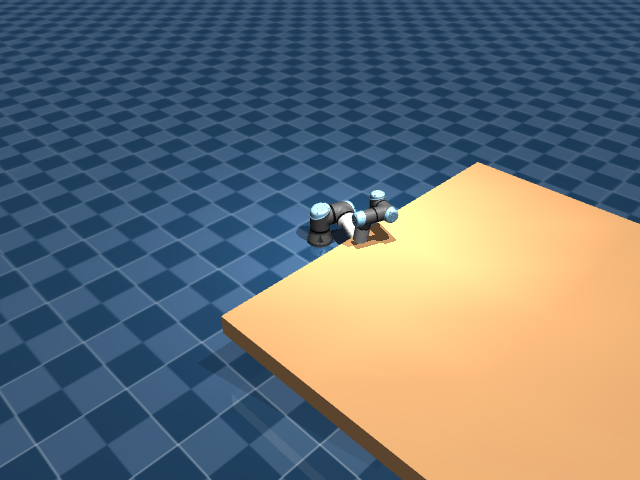

(4, 4)


In [18]:
# Use the inverse kinematics to make a start pose for the robot
sol = ur5e.invkin(ctr[0])
print(sol.q)
# visualize the position
ur5e.d.qpos[:] = sol.q
mujoco.mj_forward(ur5e.m, ur5e.d)
renderer.update_scene(ur5e.d, camera="fixed", scene_option=dict())
# show image
media.show_image(renderer.render())
# joints pose
# 0.27174445, -1.40474226, -2.07800756, -1.2296391,   1.57079635,  1.84254078
print(T1.shape)

# Effort PD controller

  0%|          | 0.002/5 [10:15<427:32:24, 307952.01s/it]

[0.2 0.3 0.1 0.  0.  0. ]



/home/viktor/.local/lib/python3.10/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 10.000000000000009/10 [00:04<00:00,  2.11it/s]


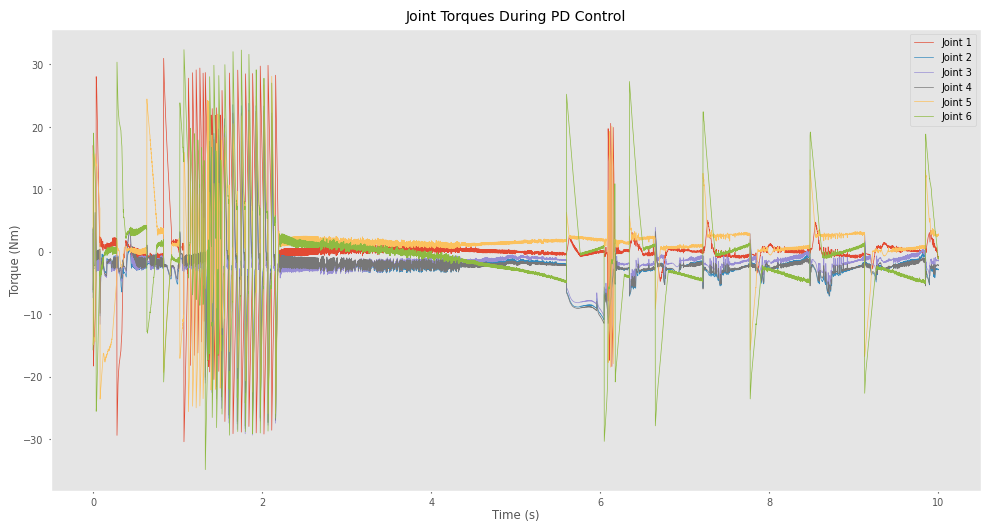

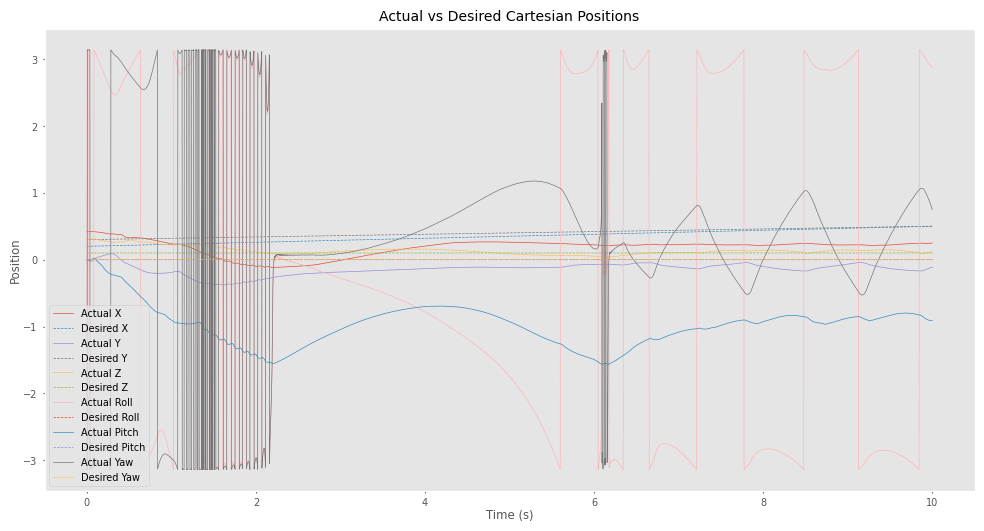

In [19]:
import numpy as np
import mujoco
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

# Define simulation parameters
showVideo = True
duration = 10  # Adjust to suit your simulation time
framerate = 30  # Hz
stepsize = ur5e.m.opt.timestep  # Assume timestep is defined in your Mujoco model
n_steps = int(np.ceil(duration / stepsize))

# Start pose (above the table)
start_q = np.array([0.27174445, -1.40474226, -2.07800756, -1.2296391, 1.57079635, 1.84254078])

# Reset simulation
mujoco.mj_resetData(ur5e.m, ur5e.d)
ur5e.d.qpos[:] = start_q
mujoco.mj_forward(ur5e.m, ur5e.d)

# Define the gains for the PD motion controller
kp_trans_val = 10  # Proportional gain for translation
kp_rot_val = 5  # Proportional gain for rotation
kd_trans = 2 * np.sqrt(kp_trans_val)
kd_rot = 2 * np.sqrt(kp_rot_val)

kp = np.diag([kp_trans_val, kp_trans_val, kp_trans_val, kp_rot_val, kp_rot_val, kp_rot_val])
kd = np.diag([kd_trans, kd_trans, kd_trans, kd_rot, kd_rot, kd_rot])

# Desired trajectory in Cartesian space
start_position = np.array([0.2, 0.3, 0.1])  # Starting position
end_position = np.array([0.5, 0.5, 0.1])  # Ending position
p = np.linspace(start_position, end_position, n_steps)  # Linear interpolation
p = np.hstack([p, np.zeros((n_steps, 3))])  # Keep the rotation fixed (for simplicity)
dp = np.gradient(p, axis=0)  # Velocities
ddp = np.gradient(dp, axis=0)  # Accelerations

# Data logging
positions = np.zeros((n_steps, 6))  # Actual positions
velocities = np.zeros((n_steps, 6))  # Actual velocities
torques = np.zeros((n_steps, 6))  # Torques applied to each joint
frames = []

# Simulation loop
progress_bar = tqdm(total=duration)
idx = 0
print(p[0])
while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)

    # Desired position, velocity, acceleration
    r_d = p[idx]
    dr_d = dp[idx]
    ddr_d = ddp[idx]

    # Compute current position and velocity
    tcp_pos = ur5e.fkine(ur5e.d.qpos)
    J = ur5e.jacob0(ur5e.d.qpos)  # Jacobian
    v_e = J @ ur5e.d.qvel  # End-effector velocity in Cartesian space
    r_e = np.concatenate([tcp_pos.t, tcp_pos.rpy(order='xyz')])  # Current Cartesian position

    # Log actual positions and velocities
    positions[idx] = r_e
    velocities[idx] = v_e

    # Compute errors
    position_error = r_d - r_e
    velocity_error = dr_d - v_e

    # PD Control law
    effort = kp @ position_error + kd @ velocity_error

    # Convert Cartesian effort to joint torques
    joint_torques = J.T @ effort
    torques[idx] = joint_torques

    # Apply torques to the robot
    ur5e.d.ctrl[:] = joint_torques

    # Advance simulation
    mujoco.mj_step(ur5e.m, ur5e.d)
    if len(frames) < ur5e.d.time * framerate and showVideo:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)
    idx += 1

progress_bar.close()
# Visualization: Plot joint torques
time = np.linspace(0, duration, n_steps)

if showVideo:
    media.show_video(frames, fps=framerate)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.plot(time, torques[:, i], label=f"Joint {i+1}")
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.title("Joint Torques During PD Control")
plt.legend()
plt.grid()
plt.show()

# Visualization: Plot actual vs desired positions
plt.figure(figsize=(12, 6))
for i, label in enumerate(["X", "Y", "Z", "Roll", "Pitch", "Yaw"]):
    plt.plot(time, positions[:, i], label=f"Actual {label}")
    plt.plot(time, p[:, i], linestyle='dashed', label=f"Desired {label}")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.title("Actual vs Desired Cartesian Positions")
plt.legend()
plt.grid()
plt.show()


# Hybrid force/motion controller

In [20]:
# Test for cartesian space positon control
# Define duration of simulation
showVideo = True
duration = 5  # (seconds)
print(f"Duration of simulation: {duration} seconds")
framerate = 30  # (Hz)
stepsize = ur5e.m.opt.timestep
n_steps = int(np.ceil(duration / stepsize))


# start pose
start_q = np.array([0.27174445, -1.40474226, -2.07800756, -1.2296391,   1.57079635,  1.84254078]) #above the table

mujoco.mj_resetData(ur5e.m, ur5e.d)  # Reset state and time.
ur5e.d.qpos[:] = start_q
mujoco.mj_forward(ur5e.m, ur5e.d)

# Define the mapping of subspace of motion controller
S_v = np.diag([1.0, 1.0, 1.0, 1.0, 1.0]) #added 0 so it does not lift the 
zero_row = np.zeros((1,5))
S_v = np.insert(S_v, 2, zero_row,axis=0)
S_v_transposed = np.linalg.pinv(S_v)

# Define the gains for the motion controller
kp_trans_val = 1
kp_rot_val = 0.001
kp_trans = np.array([kp_trans_val, kp_trans_val])
kp_rot = np.array([kp_rot_val, kp_rot_val, kp_rot_val])
kd_trans = 2*np.sqrt(kp_trans)
kd_rot = 2*np.sqrt(kp_rot)
kp = np.diag(np.concatenate((kp_trans, kp_rot), axis=0))
kd = np.diag(np.concatenate((kd_trans, kd_rot), axis=0))


ki = np.eye(5)

for i in range(2):
    ki[i][i] = 2

error_ki = 0
error_ki_force = 0

# Define the  mapping of subspace of force controller
S_f = np.array([0,0,1,0,0,0])
#S_f_transposed = np.linalg.pinv(S_f)
S_f_transposed = S_f.transpose()

# Define the gains for the force controller
k_p_lambda_val = 0.005
m_lambda_val = 1
k_i_lambda = 0.0001 ####################################################################################
k_d_lambda_val = 0.01
k_p_lambda = np.array([k_p_lambda_val])
k_d_lambda = np.array([k_d_lambda_val])
has_been_in_contact = 0

# logging and display video.
frames = []
positions_as_quat = np.zeros((n_steps, 7))
positions_as_rpy = np.zeros((n_steps, 6))
velocities = np.zeros((n_steps, 6))
accelerations = np.zeros((n_steps, 6))
forces = np.zeros((n_steps, 3))
forces_filtered = np.zeros((n_steps, 3))
force_reference = np.zeros((n_steps, 6))
control_position = np.zeros((n_steps, 6))
control_velocity = np.zeros((n_steps, 6))
control_acceleration = np.zeros((n_steps, 6))
target_positions_as_quat = np.zeros((n_steps, 7))
target_positions = np.zeros((n_steps, 6))
target_velocities = np.zeros((n_steps, 6))
target_accelerations = np.zeros((n_steps, 6))
nan_array = np.full((n_steps, 1), np.nan)


joints = []
torques = np.zeros((n_steps, 5))
lambdas = np.zeros((n_steps, 3))
p_contacts_log = np.zeros((n_steps, 4))
prev_h_e = np.array([0,0,0,0,0,0])

#Stiffness matrix for calculation of derivative of force (dlabmda_)
K_stiffness_val = 1
K_stiffness = np.diag([K_stiffness_val]*6)



# get translational part of T_pen_array
p = np.zeros((len(ctr), 2))

for i in range(len(ctr)):
    p[i] = ctr[i].t[0:2]

p = np.hstack((p, np.zeros((len(ctr), 1)), np.ones((len(ctr), 1)), np.zeros((len(ctr), 1))))
dp = np.gradient(p, axis=0)
ddp = np.gradient(dp, axis=0)

contact_points = []
contact_forces = []

do_only_once = 0

velocity_joint = np.zeros(6)
qvel = ur5e.d.qvel.copy()



mujoco.mj_resetData(ur5e.m, ur5e.d)  # Reset state and time.
ur5e.d.qpos[:] = start_q
mujoco.mj_forward(ur5e.m, ur5e.d)


# read force
lowpass = LowPassFilter(0.025, np.array([0,0,0,0,0,0]))


progress_bar = tqdm(total=duration)
idx = 0
while ur5e.d.time < duration and idx < n_steps:
    progress_bar.update(stepsize)

    #Motion controller
    #Desired trajectory
    quat_d = r2q(T0.R)
    r_d = np.array([np.array(T0.t),quat_d[1:]]).flatten()
    dr_d = np.array([0,0,0,0,0,0])
    ddr_d = np.array([0,0,0,0,0,0])

    #Desired trajectory in sub space
    vd = S_v_transposed @ r_d
    dvd = S_v_transposed @ dr_d
    ddvd = S_v_transposed @ ddr_d

    #Current position in cartesian space
    tcp_pos = ur5e.fkine(ur5e.d.qpos)

    #Analytical jacobian
    J = ur5e.jacob0(ur5e.d.qpos)
    dJ = ur5e.djacob0(ur5e.d.qpos, ur5e.d.qvel, representation=None)
    if(np.abs(np.linalg.det(J)) <= 0.001):
        print("Singular configuration ", ur5e.d.time, np.linalg.det(J))
        break

    #Current position xyz,qx,qy,qz
    quat_e = r2q(tcp_pos.R)
    r_e = np.array([tcp_pos.t, quat_e[1:] ]).flatten()
    positions_as_quat[idx] = np.concatenate((r_e, np.array([quat_e[0]])))
    positions_as_rpy[idx] = np.concatenate([tcp_pos.t, tcp_pos.rpy(order='xyz')])
    #Current endeffector velocity in cartesian space
    v_e = J @ ur5e.d.qvel
    velocities[idx] = v_e

    #Current endeffector velocity  and position in subspace
    v = S_v_transposed @ v_e 
    r = S_v_transposed @ r_e 

    #Motion controller

    error_ki += (p[idx] - r)
    #alpha_v = ddvd + kd @ (dvd - v) + kp @ (vd - r)
    alpha_p = p[idx] + kp @ (p[idx] - r) #+ ki @ error_ki
    torque_m = kp @ (p[idx] - r) + kd @ (dp[idx] - v)
    #torques[idx] = torque
    

    targetPosQuat = np.array(p[idx][:2])
    targetPosQuat = np.append(targetPosQuat, 0)
    targetPosQuat = np.append(targetPosQuat, np.array(quat_d))
    target_positions_as_quat[idx] = targetPosQuat
    target_positions[idx] = np.concatenate([p[idx][:2], np.array([0]), T0.rpy(order='xyz')])
    target_velocities[idx] = np.concatenate([dp[idx][:2], np.array([0]), np.array([0,0,0])])
    target_accelerations[idx] = np.concatenate([ddp[idx][:2], np.array([0]), np.array([0,0,0])])


    #Compute K' for rotation i quaternion space
    eta_diff = np.array([quat_d[0]*quat_e[0] - np.dot(quat_d[1:], quat_e[1:])])
    eps_diff = quat_d[0]*quat_e[1:] - quat_e[0]*quat_d[1:] - skewSymmetric(quat_e[1:])@quat_d[1:]
    quat_diff = np.concatenate((eta_diff, eps_diff))
    
    K_rot = K_(quat_diff, np.diag(kp_rot))
    alpha_p[2:] = vd[2:] + K_rot @ eps_diff
    #position in cartesian space
    pos_m = S_v @ alpha_p

    #Force controller
    #Desired force
    h_d = np.array([0,0,-5,0,0,0])
    force_reference[idx] = h_d
    lambda_d = S_f_transposed @ h_d

    #Endeffector force
    h_e = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
    contact_point = np.array([0,0,0,0])
    p_contacts,f_contacts,geom1s,geom2s,distance = ur5e.get_contact_info()

    if(len(f_contacts)):
        #print(f_contacts[0])
        h_e[0] = f_contacts[0][0]
        h_e[1] = f_contacts[0][1]
        h_e[2] = f_contacts[0][2]
        contact_point[0]  = p_contacts[0][0]
        contact_point[1]  = p_contacts[0][1]
        contact_point[2]  = p_contacts[0][2]
        contact_point[3]  = distance[0]

    forces[idx] = h_e[0:3]
    h_e = lowpass.filter(h_e)

    forces_filtered[idx] = h_e[0:3]

    
    p_contacts_log[idx] = contact_point
    
    #force in subspace
    lambda_ = S_f_transposed @ -h_e

    #Force controller
    vz = S_f_transposed @ v_e 
    
    error_ki_force += (lambda_d - lambda_)
    f_lambda = r_e[2] + k_p_lambda*(lambda_d-lambda_) + k_i_lambda*error_ki_force# k_p_lambda*(lambda_d-lambda_) - k_d_lambda * vz + k_i_lambda*error_ki_force
    #error_ki_force = error_ki_force * 0.8
    #torques_combined = torque_m.copy()
    #torque_force = S_f_transposed @ f_lambda
    #torques_combined = np.array([torque_m[0], torque_m[1],torque_force, torque_m[2], torque_m[3]])
    #torques[idx] = torques_combined
    torques[idx] = torque
    """ 
    if lambda_ < 0:
        has_been_in_contact = 1
        if(do_only_once == 0):
            #ur5e.d.time = ur5e.d.time - time
            do_only_once = 1


    if has_been_in_contact == 0:
        f_lambda = -0.003
        #time = ur5e.d.time
        ur5e.d.time = 0 """


    #f_lambda = np.clip(f_lambda, -0.04, 0.04)
    
    #f_lambda = 
    
    lambdas[idx][0] = lambda_d
    lambdas[idx][1] = lambda_
    lambdas[idx][2] = f_lambda
    #Force position in cartesian space
    pos_f = S_f * f_lambda

    r_c = pos_m + pos_f
    # turn wanted position into SE3
    wanted_position = copy.copy(T0)
    wanted_position.t = r_c[:3]
    
    joint_position = ur5e.invkin(wanted_position, ur5e.d.qpos)

    #get cartesian position
    control_position[idx] = pos_m + pos_f

    ur5e.d.ctrl[:] = joint_position.q

    #make step
    mujoco.mj_step(ur5e.m, ur5e.d)

    joints.append(np.array(ur5e.d.qpos.copy()))

    if len(frames) < ur5e.d.time * framerate and showVideo:
        renderer.update_scene(ur5e.d, camera="fixed4", scene_option=dict())
        pixels = renderer.render()
        frames.append(pixels)

    p_contacts, f_contacts, geom1s, geom2s, p_distance= ur5e.get_contact_info()

    for (p_contact, f_contact, geom1, geom2) in zip(p_contacts, f_contacts, geom1s, geom2s):
        contact_points.append(list(p_contact))
        contact_forces.append(list(f_contact))
    idx += 1

accelerations = np.gradient(velocities, axis=0)
progress_bar.close()
    
for i in range(forces.shape[0]):
    if(forces[i,2] > 0):
        print("Force z", forces[i,2], "at time", i*stepsize)
        if forces[i,2] < 300:
            print("Force z", forces[i,2], "at time", i*stepsize)
            break
        break



joints = np.array(joints)
if showVideo:
    media.show_video(frames, fps=framerate)




Duration of simulation: 5 seconds


  0%|          | 0/5 [00:00<?, ?it/s]

NameError: name 'torque' is not defined

In [ ]:
import pandas as pd


# Create DataFrame
df = pd.DataFrame({
    "actual_position_0": positions_as_rpy[:,0],
    "actual_position_1": positions_as_rpy[:,1],
    "actual_position_2": positions_as_rpy[:,2],
    "actual_position_3": positions_as_rpy[:,3],
    "actual_position_4": positions_as_rpy[:,4],
    "actual_position_5": positions_as_rpy[:,5],
    "actual_velocity_0": velocities[:,0],
    "actual_velocity_1": velocities[:,1],
    "actual_velocity_2": velocities[:,2],
    "actual_velocity_3": velocities[:,3],
    "actual_velocity_4": velocities[:,4],
    "actual_velocity_5": velocities[:,5],
    "actual_acceleration_0": accelerations[:,0],
    "actual_acceleration_1": accelerations[:,1],
    "actual_acceleration_2": accelerations[:,2],
    "actual_acceleration_3": accelerations[:,3],
    "actual_acceleration_4": accelerations[:,4],
    "actual_acceleration_5": accelerations[:,5],
    "actual_force_0": forces[:,0],
    "actual_force_1": forces[:,1],
    "actual_force_2": forces[:,2],
    "actual_force_3": nan_array.flatten(),
    "actual_force_4": nan_array.flatten(),
    "actual_force_5": nan_array.flatten(),
    "actual_force_filtered_0": forces_filtered[:,0],
    "actual_force_filtered_1": forces_filtered[:,1],
    "actual_force_filtered_2": forces_filtered[:,2],
    "actual_force_filtered_3": nan_array.flatten(),
    "actual_force_filtered_4": nan_array.flatten(),
    "actual_force_filtered_5": nan_array.flatten(),
    "force_reference_0": -force_reference[:,0],
    "force_reference_1": -force_reference[:,1],
    "force_reference_2": -force_reference[:,2],
    "force_reference_3": -force_reference[:,3],
    "force_reference_4": -force_reference[:,4],
    "force_reference_5": -force_reference[:,5],
    "control_position_0": control_position[:,0],
    "control_position_1": control_position[:,1],
    "control_position_2": control_position[:,2],
    "control_position_3": control_position[:,3],
    "control_position_4": control_position[:,4],
    "control_position_5": control_position[:,5],
    "control_velocity_0": nan_array.flatten(),
    "control_velocity_1": nan_array.flatten(),
    "control_velocity_2": nan_array.flatten(),
    "control_velocity_3": nan_array.flatten(),
    "control_velocity_4": nan_array.flatten(),
    "control_velocity_5": nan_array.flatten(),
    "control_acceleration_0": nan_array.flatten(),
    "control_acceleration_1": nan_array.flatten(),
    "control_acceleration_2": nan_array.flatten(),
    "control_acceleration_3": nan_array.flatten(),
    "control_acceleration_4": nan_array.flatten(),
    "control_acceleration_5": nan_array.flatten(),
    "positions_as_quat_0": positions_as_quat[:,0],
    "positions_as_quat_1": positions_as_quat[:,1],
    "positions_as_quat_2": positions_as_quat[:,2],
    "positions_as_quat_3": positions_as_quat[:,3],
    "positions_as_quat_4": positions_as_quat[:,4],
    "positions_as_quat_5": positions_as_quat[:,5],
    "positions_as_quat_6": positions_as_quat[:,6],
    "target_positions_as_quat_0": target_positions_as_quat[:,0],
    "target_positions_as_quat_1": target_positions_as_quat[:,1],
    "target_positions_as_quat_2": target_positions_as_quat[:,2],
    "target_positions_as_quat_3": target_positions_as_quat[:,3],
    "target_positions_as_quat_4": target_positions_as_quat[:,4],
    "target_positions_as_quat_5": target_positions_as_quat[:,5],
    "target_positions_as_quat_6": target_positions_as_quat[:,6],
    "target_positions_0": target_positions[:,0],
    "target_positions_1": target_positions[:,1],
    "target_positions_2": target_positions[:,2],
    "target_positions_3": target_positions[:,3],
    "target_positions_4": target_positions[:,4],
    "target_positions_5": target_positions[:,5],
    "target_velocities_0": target_velocities[:,0],
    "target_velocities_1": target_velocities[:,1],
    "target_velocities_2": target_velocities[:,2],
    "target_velocities_3": target_velocities[:,3],
    "target_velocities_4": target_velocities[:,4],
    "target_velocities_5": target_velocities[:,5],
    "target_accelerations_0": target_accelerations[:,0],
    "target_accelerations_1": target_accelerations[:,1],
    "target_accelerations_2": target_accelerations[:,2],
    "target_accelerations_3": target_accelerations[:,3],
    "target_accelerations_4": target_accelerations[:,4],
    "target_accelerations_5": target_accelerations[:,5],
})

# Save to CSV
df.to_csv('data/posFF_condim3_friction1_dampening100_test.csv', index=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Unpack individual components of contact points and forces
x_contact, y_contact, z_contact = zip(*contact_points)

# Find the magnitude of forces
force_magnitude = np.linalg.norm(contact_forces, axis=1)
max_magnitude = max(force_magnitude)

# make plot only for contact forces angle (45, 45)
fig, axs = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={'projection': '3d'})
#axs.scatter(x_contact, y_contact, z_contact, c=force_magnitude, cmap='jet')
temp = np.array(contact_forces)[:,2]
sc = axs.scatter(x_contact[:], y_contact[:], z_contact[:], c=temp, cmap='jet', vmin=0, vmax=15)
axs.set_title('Contact Forces')
axs.set_xlabel('X [m]')
axs.set_ylabel('Y [m]')
axs.set_zlabel('Z [m]')
axs.view_init(elev=45, azim=45)
cbar = fig.colorbar(sc, ax=axs, pad=0.05, aspect=40)
cbar.set_label('Force Magnitude [N]')
plt.savefig("contact_forces.pdf")

In [ ]:
# plot force in z direction
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
axs.plot(times[:2500], forces_filtered[:2500,2])
axs.plot(times[:2500], -force_reference[:2500,2])
axs.set_title('Force in Z direction')
axs.set_xlabel('Time [s]')
axs.set_ylabel('Force [N]')
plt.savefig("force_z.pdf")


In [ ]:
xpos = p[:,0]
ypos = p[:,1]

dxpos = dp[:,0]
dypos = dp[:,1]

ddxpos = ddp[:,0]
ddypos = ddp[:,1]

#xposition
plt.plot(xpos)
plt.title("x position")
plt.show()

plt.plot(dxpos)
plt.title("dx position")
plt.show()

plt.plot(ddxpos)
plt.title("ddx position")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Unpack individual components of contact points and forces
x_contact, y_contact, z_contact = zip(*contact_points)

# Find the magnitude of forces
force_magnitude = np.linalg.norm(contact_forces, axis=1)
max_magnitude = max(force_magnitude)

# Create a list of different viewing angles
angles = [(45, 45), (90, 90)]

# Plot contact points and forces from different angles
fig, axs = plt.subplots(len(angles), 2, figsize=(12, len(angles) * 6), subplot_kw={'projection': '3d'})

for i, angle in enumerate(angles):
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]

    # Plot contact points
    ax1.scatter(x_contact, y_contact, z_contact, c='b', marker='o')
    ax1.set_title(f'Contact Points (Angle: {angle})')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.view_init(elev=angle[0], azim=angle[1])

    # Plot contact forces with colors
    sc = ax2.scatter(x_contact, y_contact, z_contact, c=force_magnitude, cmap='jet')
    ax2.set_title(f'Contact Forces (Angle: {angle})')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.view_init(elev=angle[0], azim=angle[1])

    # Add color bar for force magnitude
    cbar = fig.colorbar(sc, ax=ax2, pad=0.05, aspect=40)
    cbar.set_label('Force Magnitude')

plt.tight_layout()
plt.show(block=True)  # Set block=True to allow for zooming and rotating

##### Position plot


In [ ]:
fig, axs = plt.subplots(7, 1, figsize=(8, 14))

axs[0].plot(np.arange(n_steps)*stepsize, positions[:,0])
axs[0].plot(np.arange(n_steps)*stepsize, T0.t[0]*np.ones(n_steps))
axs[0].set_title('Position x')

axs[1].plot(np.arange(n_steps)*stepsize, positions[:,1])
axs[1].plot(np.arange(n_steps)*stepsize, T0.t[1]*np.ones(n_steps))
axs[1].set_title('Position y')

axs[2].plot(np.arange(n_steps)*stepsize, positions[:,2])
axs[2].plot(np.arange(n_steps)*stepsize, 0.301*np.ones(n_steps))
#axs[2].set_ylim([0.2, 0.4])
axs[2].set_title('Position z')

axs[3].plot(np.arange(n_steps)*stepsize, positions[:,6])
axs[3].plot(np.arange(n_steps)*stepsize, r2q(T0.R)[0]*np.ones(n_steps))
axs[3].set_title('quat s')

axs[4].plot(np.arange(n_steps)*stepsize, positions[:,3])
axs[4].plot(np.arange(n_steps)*stepsize, r2q(T0.R)[1]*np.ones(n_steps))
axs[4].set_title('quat x')

axs[5].plot(np.arange(n_steps)*stepsize, positions[:,4])
axs[5].plot(np.arange(n_steps)*stepsize, r2q(T0.R)[2]*np.ones(n_steps))
axs[5].set_title('quat y ')

axs[6].plot(np.arange(n_steps)*stepsize, positions[:,5])
axs[6].plot(np.arange(n_steps)*stepsize, r2q(T0.R)[3]*np.ones(n_steps))
axs[6].set_title('quat z')

plt.tight_layout()
plt.show()


##### Force plot


In [ ]:

fig, axs = plt.subplots(3, 1, figsize=(8, 6))

axs[0].plot(np.arange(n_steps)*stepsize, forces[:,0])
axs[0].set_title('Force x')

axs[1].plot(np.arange(n_steps)*stepsize, forces[:,1])
axs[1].set_title('Force y')

axs[2].plot(np.arange(n_steps)*stepsize, forces[:,2])
axs[2].set_title('Force z')


plt.tight_layout()
plt.show()

for i in range(forces.shape[0]):
    if(forces[i,2] > 0):
        print("Force z", forces[i,2], "at time", i*stepsize)
        break

##### Joint pos plot

In [ ]:


fig, axs = plt.subplots(6, 1, figsize=(8, 12))

axs[0].plot(joints[:,0])
axs[0].set_title('Joint pos 0')

axs[1].plot(joints[:,1])
axs[1].set_title('Joint pos 1')

axs[2].plot(joints[:,2])
axs[2].set_title('Joint pos 2')

axs[3].plot(joints[:,3])
axs[3].set_title('Joint pos 3')

axs[4].plot(joints[:,4])
axs[4].set_title('Joint pos 4')

axs[5].plot(joints[:,5])
axs[5].set_title('Joint pos 5')

plt.tight_layout()
plt.show()


##### Torque joint plot

In [ ]:

fig, axs = plt.subplots(5, 1, figsize=(8, 12))

axs[0].plot(torques[:,0])
axs[0].set_title('Torque joint 0')

axs[1].plot(torques[:,1])
axs[1].set_title('Torque joint 1')

axs[2].plot(torques[:,2])
axs[2].set_title('Torque joint 2')

axs[3].plot(torques[:,3])
axs[3].set_title('Torque joint 3')

axs[4].plot(torques[:,4])
axs[4].set_title('Torque joint 4')

#axs[5].plot(torques[:,5])
#axs[5].set_title('Torque joint 5')

plt.tight_layout()
plt.show()



##### lambda plot

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))

axs[0].plot(lambdas[:,0])
axs[0].set_title('Lambda_d')

axs[1].plot(lambdas[:,1])
#axs[1].vlines(213, -1000, 1000, colors='b', linestyles='dashed')
axs[1].set_title('Lambda')

axs[2].plot(lambdas[:,2])
#axs[2].set_ylim(-100,100)
axs[2].set_title('F_Lambda')


plt.tight_layout()
plt.show()


##### contact pos plot

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(8, 8))

axs[0].plot(p_contacts_log[:,0])
axs[0].set_title('Contact pos x')

axs[1].plot(p_contacts_log[:,1])
axs[1].set_title('Contact pos y')

axs[2].plot(p_contacts_log[:,2])
axs[2].set_title('Contact pos z')

axs[3].plot(p_contacts_log[:,3])
axs[3].set_title('Distance to contact point')


plt.tight_layout()
plt.show()

##### Debug

In [ ]:
# append 3 zeros to the point
target_acc = np.append(target_acc, [0, 0, 0])
target_acc

In [ ]:
# Test if we can run the mucojo interactive simulation
#with mujoco.viewer.launch_passive(ur5e.m, ur5e.d) as viewer:
#    while True:
#        mujoco.mj_step(ur5e.m, ur5e.d)
#        viewer.sync()       